<a href="https://colab.research.google.com/github/Artemiy2708/ML/blob/main/%F0%9F%90%AFV_alidol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, ©<a href="https://apps.ep.jhu.edu/course-homepages/3765-605-742-deep-neural-networks" target="_blank">JHU</a> 2021 onwards</font></small><hr style="margin:0;background-color:silver">

# **[🏆🍿Netflix](https://www.kaggle.com/c/21422netflix/rules)**

See [**instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running and naming your Colab notebooks.

**(Optioal) CONSENT.** If ok with sharing your Colab for educational purposes, please check the box below with "X".

<mark>[ . . ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purpose. We understand that sharing is optional and this decision will not affect our grade in any way. 

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q --upgrade imgaug==0.2.5 > log.txt  # avoids warning/conflict with scipy upgrade
!pip install -q --upgrade scipy >>log.txt  # upgrades 1.4 to 1.8

In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 21422netflix             # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
# !kaggle competitions leaderboard --show                       # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 21422netflix


In [ ]:
%%time
%%capture
%reset -f
!pip -q install scikit-surprise
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all" 
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, plotly.express as px, surprise
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=1000, precision=2, edgeitems=20, suppress=True)
pd.set_option('max_columns', 20, 'precision', 2, 'display.max_rows', 4)

CPU times: user 433 ms, sys: 59.1 ms, total: 492 ms
Wall time: 5 s


The matrix below contains ratings that users (user id or `uid`) have given to the movies (movie ID or `mid`). It is 85% blank, but the original dataset was 99% sparse (with ~1 rating per user) [&#127910;](https://youtu.be/ImpV70uLxyw). Your task is not to fill the whole matrix, but to impute `NaN` values in `XY_Netflix.csv`, which is an equivalent representation of `XY_Netflix_matrix.csv`. This is a collaborative filtering problem, where observations and features have some implicit relation. Recall that typically we expect independent observations in a sample (unless we have a time series or video of image frames, etc.). Here our model needs to learn and leverage the dependencies from observed movie ratings. Clustering techniques might be more intuitive here. [Truncated SVD](https://scikit-learn.org/stable/modules/decomposition.html#lsa) is also popular. Supervised models can be used as well, if we can build features describing our users (which we would treat as observations). Note that we have no other information on users except what they have ranked (which might suggest the cluster they belong to, which might offer unobserved (latent) features). [&#127910;](https://youtu.be/8wLKuscyO9I) Since users relate to other users through the movies they ranked, this can also be presented as a [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph).

In [ ]:
#dfMtx = pd.read_csv('XY_Netflix_matrix.csv', low_memory=False); dfMtx

In [ ]:
#f = px.imshow(dfMtx.iloc[:2000,:].T, color_continuous_scale='RdBu_r', aspect='auto');  # movies by users (transposed for visual convenience)
#f.update_layout(margin=dict(l=0,r=0,b=0,t=0))

In [ ]:
#dfMtx.info()   # note the datatypes and any missing values

The dataframe below is another representation of the matrix form above. It lists the `uid`$\times$`mid`locations of the values you need to predict (those with `NaN`) and all other non-zero values in the matrix above.

In [ ]:
df = pd.read_csv('XY_Netflix.csv', low_memory=False); df  # user ID, movie ID, rating. NaN=requires predictions

,uid,mid,rtg
0,1,1,NaN
1,2,2,NaN
...,...,...,...
7402070,49692,126,4.0
7402071,9783,37,1.0


In [ ]:
# df.rtg.fillna(0).astype(int).value_counts().to_frame().T   # rating frequencies. 0 represents NaN

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

**Student's Section** (between ⏳ symbols): add your code and documentation here.

## **Task 1. Preprocessing Pipeline**
 
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc. 
1. Why did you choose these elements? (Something in EDA, prior experience,...? Btw, EDA is not required)
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

**Student's answer:**
The other NaN imputing approaches did not work in our case, we tried median, mean worked better
Just dropping them is not the method suitable here as matrix has too many NaN values.
The whole preprocessing pipeline structure is similar to the baseline.
The main challenge was to understand how SVD works mathematically in order to understand how actually we need to apply it in our model.

## **Task 2. Modeling Approach**
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful. 

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

**Student's answer:**
We did not try other models as we covered only several unsupervised learning approaches
We made SVD = 5 and number of iterations equal to 60, just tuning hyperparametres. It gave a significant boost to out score on validation (Public LB).

Below is a baseline model that produces the baseline result on Kaggle leaderboard (LB).

In [ ]:
# if 'dfMtx' in vars(): del dfMtx   # release ~400MB RAM
dfK = df[df.rtg!=df.rtg]          # uid-mid-rtg for Kaggle submission (contains NaN ratings)
dfX = df[df.uid.isin(dfK.uid.unique())]  # all ratings on users requiring predictions (as adjacency list)
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')  # convert to (adjacency) matrix format
dfX_est = dfX.fillna(dfX.mean())  # fill NaN with movies' average ratings, save as
n, p = dfX.shape                  # number of users and movies

In [ ]:
np.random.seed(0)
mask = ~np.isnan(dfX)
masked = dfX[mask]
for _ in range(60):                             # apply truncated SVD approximation a few times
  U, D, Vt = svds(dfX_est, k=5)               # find k eigenvectors (U,V) and eigenvalues (D)
  dfX_est.loc[1:n, 1:p] = U @ np.diag(D) @ Vt  # k-dimensional estimate (as np array) of dfM (we expect ratings' noise to reduce)
  dfX_est[mask] = masked   # place original/known ratings back into estimated uid×mid matrix 

In [ ]:
# Submissions are scored on accuracy, not on continuous/regression error
dfX_est_L = dfX_est.unstack().reset_index().round(0).astype(int).rename(columns={0:'rtg'})  # tall format with integer ratings
dfK = dfX_est_L.merge(dfK, on=['mid','uid'], suffixes=['','_']).drop('rtg_', axis=1)
dfK.index = (dfK.uid-1)*dfK.mid.max()+dfK.mid
dfK['rtg'] = dfK['rtg'].clip(1, 5)  # restrict the range to 1,2,3,4,5 . Thanks to Yannis & Liz, See Piazza @67_f1
dfK

,mid,uid,rtg
1,1,1,2
147061,1,388,3
...,...,...,...
5568899,379,14655,3
5647180,380,14861,4


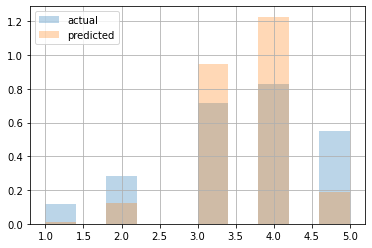

In [ ]:
# evaluate unconditional distributions of observed and predicted ratings. Learn from the differences to focus on wrong predictions
plt.subplot(1, 1, 1)
_ = df.rtg.dropna(axis=0).astype(int).hist(density=True, alpha=0.3);
_ = dfK.rtg.astype(int).hist(density=True, alpha=0.3);
_ = plt.legend(['actual','predicted']);

In [ ]:
ToCSV(dfK[['rtg']].sort_index(), 'MySubmission')

# **References:**

1. https://hastie.su.domains/ISLR2/ISLRv2_website.pdf

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 49 sec


## 💡**Starter Ideas**

1. Tune model **hyperparameters**. 
  1. SVD's $k$ might be user-perceived movie genres (perhaps, an average user categorizes movies into just 5 or 50 genres) [🎦](https://youtu.be/sooj-_bXWgk)
1. Try smarter **sampling** from the training set to avoid using all observations (due to time constraint)
  1. Some movies may have consistent high/low ratings and do not distinguish user preferences (just add to runtime)
1. Try SVD on groups (say movie genres) with the largest impact on overall accuracy
1. Try smarter initial imputation, perhaps, conditioned on movie genres or other observed features
1. Try clustering techniques from [SKL](https://scikit-learn.org/stable/modules/clustering.html)
1. Try engineering new features using Movies' data (`movies.csv`)
1. Try supervised approach on clusters or engineered features
1. Try shift/scale ratings. Recall: SVD seeks largest quadratic error from mean without shifting first, like variance does. Since $1^2\ll5^2$, SVD might work better for higher ratings.
  1. Note: the baseline model squeezes predictions towards ratings 3 and 4, which is not the original distribution.
1. Try feature restriction, selection, and regularization (see ESL pp.140-141)
1. Do a thorough EDA. Are there movies that are liked by most viewers?
1. Try Robust PCA (RPC) [🎦](https://www.youtube.com/watch?v=yDpz0PqULXQ), [RPCA Github](https://github.com/dganguli/robust-pca)
1. Find polarized movies and tune for them (like "*Napoleon Dynamite*"). See [&#127910;](https://youtu.be/ImpV70uLxyw)
1. Try KNN [📄](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.143.596&rep=rep1&type=pdf), [📄](https://scholar.google.com/scholar?q=knn+netflix+prize)
1. Learn more methods to build/use latent representations [🎦](https://youtu.be/n3RKsY2H-NE),  [📄](https://ieeexplore.ieee.org/abstract/document/5197422), [📄](https://scholar.google.com/scholar?q=netflix+prize+challenge), [&#127910;](https://www.youtube.com/results?search_query=netflix+prize+svd), [📄](https://www.aaai.org/Papers/AAAI/2002/AAAI02-029.pdf), 